In [1]:
%matplotlib inline
import sys
from pycocotools.coco import COCO
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import skimage
import skimage.io as io
import copy
from collections import defaultdict
import cv2

In [2]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
colors_recykling = {'metals_and_plastics':'yellow',
                    'non-recyclable': 'gray',
                    'unknown':'gray',
                    'glass': 'green',
                    'paper': 'blue',
                    'bio': 'brown',
                    'other': 'pink'}

# TrashNet pictures
- classes: 5, 6th is a 'trash' and should be manually assigned to categories in order to use them
- annotation: class per image

In [4]:
dataDir = '/dih4/dih4_2/wimlds/data/TrashNet-classify'
categories = os.listdir(dataDir)
categories.remove('trash')
images = []
nr_images = 0
for category in categories:
    for img in os.listdir(os.path.join(dataDir,category)):        
        images.append(f'{dataDir}/{category}/{img}')
    nr_images+=len(os.listdir(os.path.join(dataDir,category)))
    
nr_cats = len(categories)

print(f'There are {len(categories)} categories.')
print(f'There are {nr_images} images')

There are 5 categories.
There are 2194 images


plastic plastic14.jpg
cardboard cardboard349.jpg
plastic plastic37.jpg
cardboard cardboard382.jpg


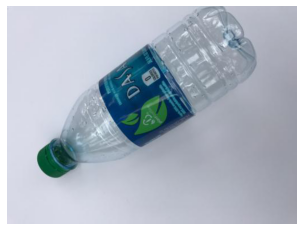

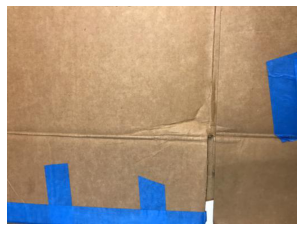

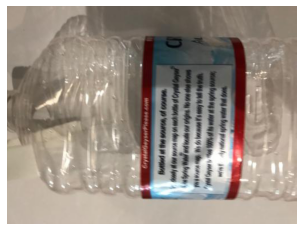

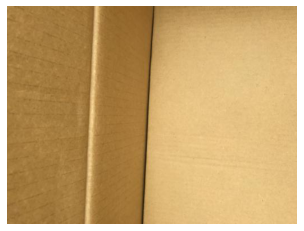

In [5]:
#load and display image
import random
for i in range(1,5):
    rand_cat = random.choice(categories)
    img_name = random.choice(os.listdir(os.path.join(os.path.join(dataDir,rand_cat))))    
    I = io.imread(os.path.join(dataDir,rand_cat,img_name))
    plt.figure()
    plt.imshow(I)
    plt.axis('off')
    print(rand_cat, img_name)

In [6]:
categories_count = {category: len(os.listdir(os.path.join(dataDir,category))) for category in categories}
categories_count

{'cardboard': 291, 'glass': 501, 'metal': 410, 'paper': 510, 'plastic': 482}

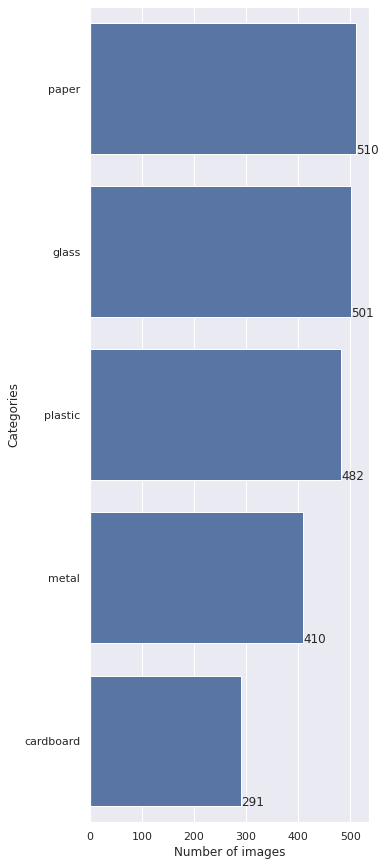

In [7]:
f, ax = plt.subplots(figsize=(5,15))

cat_histogram = np.array([categories_count[category] for category in categories])

# Convert to DataFrame
df = pd.DataFrame({'Categories': categories, 'Number of images': cat_histogram})
df = df.sort_values('Number of images', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of images", y="Categories", data=df,
            label="Total", color="b")
show_values_on_bars(plot_1, "h", 0.3)

In [8]:
def trashnet_to_detectwaste(label):
    glass = ['glass']
    metals_and_plastics = ['metal', 'plastic']    
    paper = ['paper', 'cardboard']
    
    if (label in glass):
            label="glass"
    elif (label in metals_and_plastics):
            label="metals_and_plastics"
   
    elif (label in paper):
            label="paper"

    else:
        print(label, "is non-trashnet label")
        label = "unknown"
    return label

In [9]:
detect_waste_count = defaultdict(int)
for category in categories:
    detect_waste_count[trashnet_to_detectwaste(category)]+=categories_count[category]
detect_waste_categories = list(detect_waste_count.keys())
detect_waste_count

defaultdict(int, {'paper': 801, 'glass': 501, 'metals_and_plastics': 892})

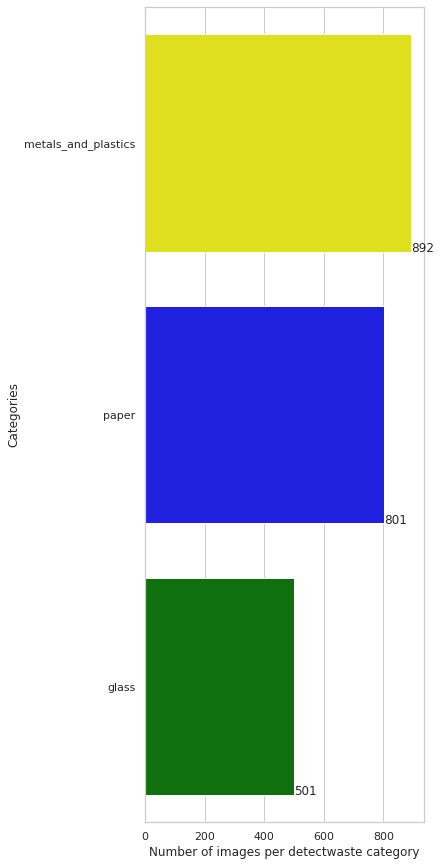

In [10]:

f, ax = plt.subplots(figsize=(5,15))

detect_waste_cat_histogram = np.array([detect_waste_count[category] for category in detect_waste_categories])

# Convert to DataFrame
df = pd.DataFrame({'Categories': detect_waste_categories, 'Number of images per detectwaste category': detect_waste_cat_histogram})
df = df.sort_values('Number of images per detectwaste category', 0, False)

# Plot the histogram
sup_cat = df.loc[:,'Categories'].tolist()
colors = [colors_recykling[cat] for cat in sup_cat]

sns.set(style="whitegrid")
sns.set_palette(sns.color_palette(colors))
plot_1 = sns.barplot(x="Number of images per detectwaste category", y="Categories", data=df,
            label="Total")
show_values_on_bars(plot_1, "h", 0.3)

### Number of images per image shape

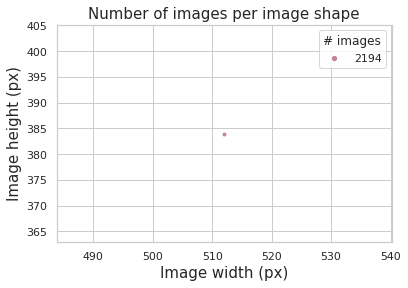

In [11]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}

for img in images:
    
    try:
        im = plt.imread(img)
        width=np.shape(im)[1]
        height=np.shape(im)[0]

        key = str(width)+'-'+str(height)
        if key in img_shapes_keys:
            shape_id = img_shapes_keys[key]
            shape_freqs[shape_id] += 1
        else:
            img_shapes_keys[key] = len(widths)
            widths.append(width)
            heights.append(height)
            shape_freqs.append(1)
    except:
        pass

d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plt.xlabel('Image width (px)', fontsize=15)
plt.ylabel('Image height (px)', fontsize=15)
plot = plot.set_title('Number of images per image shape',fontsize=15)